In [1]:
#!pip install transformers
#!pip install datasets
#!pip install evaluate

from consts import ProductType, Sentiment
from amazon_scrapping import get_scrapped_reviews, filter_and_format_reviews

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
import pandas as pd
from typing import Sequence, Dict
from sklearn.model_selection import train_test_split
import numpy as np
import evaluate
import pickle
import torch

In [2]:
label_to_numeric: Dict[str, int] = {"POSITIVE": 0, "NEUTRAL": 1, "NEGATIVE": 2}

In [3]:
reviews_with_labels: list[tuple[str, Sentiment]] = []

for product in ProductType:
    raw_reviews = get_scrapped_reviews(product_type=product, inout_folder="scrapped_data")
    reviews_with_labels.extend(filter_and_format_reviews(raw_reviews=raw_reviews, suppress_errors=True))

reviews: Sequence[str] = [rev_label[0] for rev_label in reviews_with_labels]
labels: Sequence[int] = [label_to_numeric[rev_label[1]] for rev_label in reviews_with_labels]

In [4]:
df_text: pd.DataFrame = pd.DataFrame({"text": reviews})
df_labels: pd.DataFrame = pd.DataFrame({"label": labels})

X_train, X_test, Y_train, Y_test = train_test_split(df_text, df_labels, test_size=0.25, random_state=100)


df_train: pd.DataFrame = pd.concat([X_train, Y_train], axis=1)
df_test: pd.DataFrame = pd.concat([X_test, Y_test], axis=1)

print(df_labels.value_counts())
print(df_train["label"].value_counts())
print(df_test["label"].value_counts())

df_train.to_csv("./csv_data/train_more_neutral.csv", index=False)
df_test.to_csv("./csv_data/test_more_neutral.csv", index=False)
df_train[0:10]

label
0        17494
1         3596
2         2206
dtype: int64
0    13121
1     2674
2     1677
Name: label, dtype: int64
0    4373
1     922
2     529
Name: label, dtype: int64


,text,label
13351,nach drei Monaten Nutzung läuft der Kaffee obe...,2
15721,Diese Tabs machen das Geschirr immer zuverläss...,0
8263,Die Kanne sieht super aus und macht einen qual...,0
22499,Ich bin sehr zufrieden .👍,0
10670,Die Thermoskanne hält wirklich unglaublich lan...,1
2344,Es wurden bereits eine ganze Reihe guter Rezen...,0
11299,Eigentlich bin ich überzeugte Emsabecher Besit...,1
18990,Ich kann mich nicht beklagen. Die Tabs machen ...,0
7026,Ich würde den Becher nur weiterempfehlen. Gut...,0
3289,Den Emsa Travel Mug kenne ich bereits in der k...,1


In [6]:
df_train = pd.read_csv("./csv_data/train_more_neutral.csv")
df_test = pd.read_csv("./csv_data/test_more_neutral.csv")

In [7]:
df_train_0 = df_train[df_train["label"] == 0].sample(frac=1.0)
df_train_1 = df_train[df_train["label"] == 1].sample(frac=1.0)
df_train_2 = df_train[df_train["label"] == 2].sample(frac=1.0)
df_train_0 = df_train_0[0:1677]
df_train_1 = df_train_1[0:1677]
df_train_2 = df_train_2[0:1677]

df_test_0 = df_test[df_test["label"] == 0].sample(frac=1.0)
df_test_1 = df_test[df_test["label"] == 1].sample(frac=1.0)
df_test_2 = df_test[df_test["label"] == 2].sample(frac=1.0)
df_test_0 = df_test_0[0:529]
df_test_1 = df_test_1[0:529]
df_test_2 = df_test_2[0:529]

df_test_balanced = pd.concat((df_test_0, df_test_1, df_test_2))
df_train_balanced = pd.concat((df_train_0, df_train_1, df_train_2))
print(df_test_balanced["label"].value_counts())
print(df_train_balanced["label"].value_counts())
df_train_balanced.to_csv("./csv_data/train_more_neutral_balanced.csv", index=False)
df_test_balanced.to_csv("./csv_data/test_more_neutral_balanced.csv", index=False)

0    529
1    529
2    529
Name: label, dtype: int64
0    1677
1    1677
2    1677
Name: label, dtype: int64


In [4]:
df_train = pd.read_csv("./csv_data/train.csv")
df_test = pd.read_csv("./csv_data/test.csv")

X = list(df_train["text"])
X_test = list(df_test["text"])
Y = list(df_train["label"])
Y_test = list(df_test["label"])

In [5]:
tokenizer: transformers.models.bert.tokenization_bert_fast.BertTokenizerFast = AutoTokenizer.from_pretrained("bert-base-german-cased")

X_train_tokenized = tokenizer(X, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [6]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(X_train_tokenized, Y)
val_dataset = Dataset(X_test_tokenized, Y_test)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
model = model.to('cuda')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin 

In [17]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [25]:
torch.cuda.empty_cache()
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch"
)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 1.0]).to('cuda'))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5726
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 358
  Number of trainable parameters = 109083651


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.174593,0.450840,0.348625,0.353808,0.334963


***** Running Evaluation *****
  Num examples = 4343
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=358, training_loss=0.8539700641312413, metrics={'train_runtime': 636.0693, 'train_samples_per_second': 9.002, 'train_steps_per_second': 0.563, 'total_flos': 1506587429910528.0, 'train_loss': 0.8539700641312413, 'epoch': 1.0})

In [26]:
trainer.save_model("balanced-1epochs")

Saving model checkpoint to balanced-1epochs
Configuration saved in balanced-1epochs/config.json
Model weights saved in balanced-1epochs/pytorch_model.bin


In [27]:
### Testing model ###
model_2 = AutoModelForSequenceClassification.from_pretrained("balanced-1epochs")
model_2.to('cuda')

loading configuration file balanced-1epochs/config.json
Model config BertConfig {
  "_name_or_path": "balanced-1epochs",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file balanced-1epochs/pytorch_model.bin
All model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [28]:
text = "gut becher"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.1536427 , 0.24032044, 0.60603684]], dtype=float32)

In [29]:
predictions_train = trainer.predict(train_dataset)
predictions_test = trainer.predict(val_dataset)
predictions_train = predictions_train[0].argmax(axis=1)
predictions_test = predictions_test[0].argmax(axis=1)
#print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 5726
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


***** Running Prediction *****
  Num examples = 4343
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


REPORT TRAIN
              precision    recall  f1-score   support

    positive     0.6401    0.8418    0.7272      2054
     neutral     0.7066    0.5261    0.6031      1895
    negative     0.8166    0.7417    0.7774      1777

    accuracy                         0.7063      5726
   macro avg     0.7211    0.7032    0.7026      5726
weighted avg     0.7169    0.7063    0.7017      5726



[]

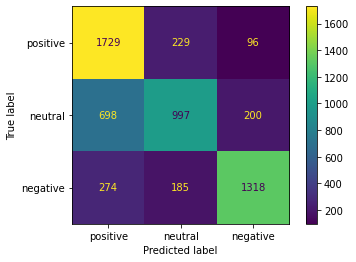

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


names = ["positive", "neutral", "negative"]

print("REPORT TRAIN")
print(classification_report(Y, predictions_train, target_names=names, digits=4))
matrix = confusion_matrix(Y, predictions_train)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()

REPORT TEST
              precision    recall  f1-score   support

    positive     0.7338    0.5214    0.6097      3124
     neutral     0.1454    0.2677    0.1885       635
    negative     0.1667    0.2723    0.2068       584

    accuracy                         0.4508      4343
   macro avg     0.3486    0.3538    0.3350      4343
weighted avg     0.5715    0.4508    0.4939      4343



[]

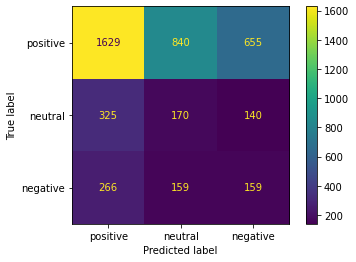

In [31]:
print("REPORT TEST")
print(classification_report(Y_test, predictions_test, target_names=names, digits=4))
matrix = confusion_matrix(Y_test, predictions_test)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=names)
disp.plot()
plt.plot()